# PREDICTING using the saved model of:

In [1]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

import albumentations as alb

In [2]:
HOMEDIR = r"/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/CaseStudy2/Kaggle-PekingAutonomousDriving/pku-autonomous-driving/"
#HOMEDIR = '../input/pku-autonomous-driving/'

## resnet-18 centernet , 6 epochs , focal loss , with mask images
#model_path = r"/home/rohit/SRH/CaseStudy2/Models/manmeet_FOLLOWUP-center-resnet-focal-mask-1/model_epoch_0.pth"
model_path = r"/home/rohit/SRH/CaseStudy2/FOLLOWUP_manmeet_center-resnet-focal-mask-1_20200314_0800/model_epoch_8.pth"

OUTDIR = r"/home/rohit/SRH/CaseStudy2/FOLLOWUP_manmeet_center-resnet-focal-mask-1_20200314_0800/rohit8/"

insertNum = '_8_'

# Basic info loading

## data, camera matrix specification


## train.csv   has   ImageId, PredictionString

## Prediction String    model# yaw pitch roll x y z  and the same for multiple cars

In [3]:
dfTrain = pd.read_csv(HOMEDIR + 'train.csv')
dfTest = pd.read_csv(HOMEDIR + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)

In [4]:
dfTrain.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [5]:
bad_images_list = ["ID_1a5a10365","ID_4d238ae90","ID_408f58e9f","ID_bb1d991f6","ID_c44983aeb"]
for bad_id in bad_images_list:
    #plt.imshow( cv2.imread(HOMEDIR + 'train_images/' + bad_id + '.jpg')[:,:,::-1] )
    #plt.show()
    pass
print(f"full df len = {len(dfTrain)}")
drop_dfTrain = dfTrain.set_index("ImageId").drop( index=bad_images_list )
dfTrain = drop_dfTrain.reset_index()
print(f"post removal of bad entries len = {len(dfTrain)}")

full df len = 4262
post removal of bad entries len = 4257


# Set swtich for very small data run

In [6]:
TEST_SWITCH_ON = True

In [7]:
if TEST_SWITCH_ON:
    dfTrain = dfTrain[:200]
    dfTest  = dfTest[:20]

In [8]:
def str2coords(ps, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
# from the prediction string entries, create a dict of each car data
    coords = []
    for ps_entry in np.array(ps.split()).reshape([-1, 7]):
        dictval = dict(zip(names, ps_entry.astype('float')))
        coords.append(dictval)
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

# 2D Visualization

In [9]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

In [10]:
def read_image(path):
    img = cv2.imread(path)
    #img = np.array(img[:, :, ::-1]) # alternative way to convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    return img

In [11]:
def convert_to_img_coords(ps):
# convert the camera coords x,y,z to the image coords
    coords = str2coords(ps)
    x_list = [c['x'] for c in coords]
    y_list = [c['y'] for c in coords]
    z_list = [c['z'] for c in coords]
    P = np.array(list(zip(x_list, y_list, z_list))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_x_list = img_p[:, 0]
    img_y_list = img_p[:, 1]
    img_z_list = img_p[:, 2]
    return img_x_list, img_y_list

# 3D Visualization

In [12]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [13]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

# Average ratios of the spanX, spanY and spanZ  by groups decided by me

GroupNo based on Z / X value bin.
GroupNo     Xspan       Yspan       Zspan       Yspan/Xspan     Zspan/Xspan
1           1.96        1.58        3.78		0.80            1.92
2           2.08        1.65        4.49        0.80            2.15
3           2.03        1.57        4.86        0.78            2.38

average of all these
GroupNo     Xspan       Yspan       Zspan       Yspan/Xspan     Zspan/Xspan
            1.00        0.79        2.15        0.79            2.15

In [14]:
def visualize(img, coords):
    ## want to visualize 
    x_l = 1.00
    y_l = 0.79
    z_l = 2.15
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        ## the yaw and pitch is interchanged in the data provided
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

# Steps to preprocess input image

In [15]:
# Original dimensions of the Train and Test images
ORIG_W = 3384
ORIG_H = 2710

# The dimensions we want to use for processing: keeping ratio of width:height = 1:4
IMG_WIDTH = 2048
IMG_HEIGHT = 512
MARGIN_W = ORIG_W // 4  # 846

MODEL_SCALE = 8  # mask shrink rate

FX, FY = 2304.5479,  2305.8757
CX, CY = 1686.2379, 1354.9849
def XYZ2UV(x,y,z):
    u = FX * x / z + CX
    v = FY * y / z + CY
    return u,v
def UVZ2XY(u,v,z):
    x = z * (u - CX) / FX
    y = z * (v - CY) / FY
    return x,y

#
# u is horizontal dimension and v is vertical dimension
#
def VU2maskVU(v,u):  
    mask_V = (v - ORIG_H // 2) * IMG_HEIGHT / (ORIG_H // 2) / MODEL_SCALE
    mask_U = (u + MARGIN_W) * IMG_WIDTH  / (ORIG_W + 2*MARGIN_W) / MODEL_SCALE
    return mask_V, mask_U
def maskVU2VU(mask_v_float, mask_u_float):
    v = ORIG_H // 2 + mask_v_float * MODEL_SCALE / IMG_HEIGHT * (ORIG_H // 2)
    u = mask_u_float * MODEL_SCALE * (ORIG_W + 2*MARGIN_W) / IMG_WIDTH - MARGIN_W
    return v, u

## assertion usage
REGR_TARGETS = sorted( ["yaw","pitch_sin", "pitch_cos", "roll", "udiff", "vdiff", "z"] )
def _regr_preprocess(regr_dict, vdiff, udiff):
    """ vdiff(h orientation), udiff is regression target """
    regr_dict["vdiff"] = vdiff
    regr_dict["udiff"] = udiff

    # Roll
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    
    # Pitch
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])

    # Regress log(Z)
    regr_dict["z"] = np.log(regr_dict["z"])
    
    regr_dict.pop('x')
    regr_dict.pop('y')
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict, mask_V_pos, mask_U_pos):
    # convert log(z) back to z
    regr_dict["z"] = np.exp(regr_dict["z"])

    _v, _u = maskVU2VU( mask_V_pos + regr_dict["vdiff"], mask_U_pos + regr_dict["udiff"] )
    regr_dict["x"], regr_dict["y"] = UVZ2XY(_u, _v, regr_dict["z"])

    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)

    ## Pitch
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :MARGIN_W]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')
def preprocess_mask_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.zeros_like(img).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # linear interpolate
    return (img / 255).astype('float32')


def draw_msra_gaussian(heatmap, center, sigma):
    # tmp_size = sigma * 3
    tmp_size = np.ceil(sigma * 3).astype(int)
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap

def make_heatmap(m, v_arr, u_arr, z_arr):
    for v,u,z in zip(v_arr, u_arr, z_arr):
        # sigma = 1000 / 3.  / z / MODEL_SCALE
        sigma = 800 / 3.  / z / MODEL_SCALE
        m = draw_msra_gaussian(m, (u,v), sigma)
    return m
        

def get_mask_and_regr(img, labels):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = convert_to_img_coords(labels)
    z_arr = [e["z"] for e in coords]
    
    mask_V_arr_float, mask_U_arr_float = VU2maskVU( ys, xs )

    # use floor floowing paper
    mask_V_arr = np.floor( mask_V_arr_float ).astype('int')
    mask_U_arr = np.floor( mask_U_arr_float ).astype('int')
    mask_V_diff = mask_V_arr_float - mask_V_arr
    mask_U_diff = mask_U_arr_float - mask_U_arr

    # make heatmap
    mask = make_heatmap(mask, mask_V_arr, mask_U_arr, z_arr)
    
    for mask_V,mask_U, vdiff,udiff, regr_dict in zip(mask_V_arr,mask_U_arr,mask_V_diff,mask_U_diff, coords):
        if mask_V >= 0 and mask_V < IMG_HEIGHT // MODEL_SCALE and mask_U >= 0 and mask_U < IMG_WIDTH // MODEL_SCALE:
            regr_dict = _regr_preprocess(regr_dict, vdiff, udiff)
            regr[mask_V, mask_U] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

In [16]:
# verifying that the converion to and back of the regression targets working

xyz = [3.,6.,24.]
__reg = _regr_preprocess({"id":"_test","x":xyz[0],"y":xyz[1],"z":xyz[2], "yaw":0.2,"pitch":-1.11,"roll":0. }, 0,0)
print(__reg)
u,v = XYZ2UV(xyz[0],xyz[1],xyz[2])
ma_v, ma_u = VU2maskVU(v, u)

__regbak = _regr_back(__reg, ma_v, ma_u)
print(__regbak)

{'z': 3.1780538303479458, 'yaw': 0.2, 'roll': -3.141592653589793, 'vdiff': 0, 'udiff': 0, 'pitch_sin': -0.8956986856800476, 'pitch_cos': 0.4446615167417068}
{'z': 24.000000000000004, 'yaw': 0.2, 'roll': 0.0, 'vdiff': 0, 'udiff': 0, 'pitch_sin': -0.8956986856800476, 'pitch_cos': 0.4446615167417068, 'x': 2.9999999999999973, 'y': 6.000000000000002, 'pitch': -1.11}


In [17]:
def vis_mask(img, mask):
    _mm = np.repeat( np.repeat(mask, 8, axis=0), 8, axis=1 )[:,:, None]
    _mm = np.repeat(_mm, 3, axis=-1)
    _mm [:,:,1] = 0 ; _mm[:,:,2] = 0
    
    tmp =  np.clip( 0.8 * img + 0.4 * _mm, 0,1)
    tmp[ _mm[:,:,0]==1 ] = [0,1,1]
    plt.figure(figsize=(16,16))
    plt.imshow( tmp , alpha=0.3)
    plt.grid()
    plt.show()


# PyTorch Dataset

In [18]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, mask_root_dir, training=True):
        self.df = dataframe
        self.root_dir = root_dir
        self.mask_root_dir = mask_root_dir  # ignore mask
        self.training = training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        ## Read image
        img0 = cv2.imread(img_name)[:,:,::-1]
        img = preprocess_image(img0.astype(float))
        img = np.rollaxis(img, 2, 0)
        
        ## Read ignore mask
        ign_img0 = cv2.imread(self.mask_root_dir.format(idx), cv2.IMREAD_GRAYSCALE)
        if ign_img0 is None:  # where there is no mask image available
            ign_img0 = np.zeros((ORIG_H, ORIG_W), dtype='float32')

        ign_img = np.array(ign_img0).astype('float32') / 255.
        
        # ignore mask for CNN
        ign_img_for_feed = preprocess_mask_image(ign_img0)
        ign_img_for_feed = np.expand_dims(ign_img_for_feed, 0)  # h,w -> 1,h,w
        
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr, ign_img, ign_img_for_feed]

In [19]:
train_images_dir = HOMEDIR + 'train_images/{}.jpg'
test_images_dir = HOMEDIR + 'test_images/{}.jpg'
train_masks_dir = HOMEDIR + 'train_masks/{}.jpg'
test_masks_dir = HOMEDIR + 'test_masks/{}.jpg'

df_train, df_dev = train_test_split(dfTrain, test_size=0.1, random_state=1042)
df_test = dfTest

## Create objects of the class type Dataset -  one for each data set
train_dataset = CarDataset(df_train, train_images_dir, train_masks_dir)
dev_dataset = CarDataset(df_dev, train_images_dir, train_masks_dir)
test_dataset = CarDataset(df_test, test_images_dir, test_masks_dir)

# PyTorch Model

In [20]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, input_channels=3):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32



def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

In [22]:
USEMASK = True

class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = resnet18(pretrained=False, input_channels=6)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

        if USEMASK:
            self.conv0 = double_conv(5 + 1, 64)
        else:
            self.conv0 = double_conv(5, 64)
            
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        if USEMASK:
            feats8, feats16, feats32 = self.base_model(x0)  ## C=6 : rgb(3)+mask(1)+mesh(2)
        else:
            feats8, feats16, feats32 = self.base_model(x)

        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

# Load the saved model

In [23]:
# Gets the GPU if there is one, otherwise the cpu
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)


cpu


In [24]:
saved_model = CentResnet(8).to(device)

In [25]:
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
saved_model.eval()

CentResnet(
  (base_model): ResNetFeatures(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
      )
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2

In [27]:
model = saved_model

In [28]:
type(model)

__main__.CentResnet

In [29]:
def infer_image(img, ign_mask_for_feed):  # shape:[B,C,H,W]
    return model( torch.from_numpy( np.concatenate((img, ign_mask_for_feed),axis=1) ).to(device) )

In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def postprocess_heatmap(logits, thresh=0.45):
    prob = sigmoid(logits)
    mp2d = torch.nn.MaxPool2d(3, stride=1, padding=1, dilation=1, return_indices=False, ceil_mode=False)
    out = mp2d( torch.Tensor([[prob]]) ).numpy()[0][0]
    return (prob == out) & (prob > thresh)

In [31]:
DISTANCE_THRESH_CLEAR = 2


In [32]:
def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

In [33]:
def extract_coords(prediction, ign_mask):
    assert ign_mask.shape[0] == ORIG_H   #
    logits = prediction[0]
    regr_output = prediction[1:]
    points_mat = postprocess_heatmap(logits) 
    points = np.argwhere( points_mat > 0 )
    
    col_names = sorted(REGR_TARGETS)  # vdiff,udiff,z,yaw,pitch_sin,pitch_cos,roll
    coords = []
    for r, c in points:           
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        
        # use heatmap-peak (V,U) position
        regr_backed = _regr_back(regr_dict, r, c)
        
        _U, _V = XYZ2UV(regr_backed["x"], regr_backed["y"], regr_backed["z"])
        _U, _V = int(_U), int(_V)
        if _V>=0 and _V<ORIG_H and _U>=0 and _U<ORIG_W and ign_mask[_V,_U] > 0.5:  # floor(u), floor(v)
            # print("point is in ignore_mask")
            continue

        coords.append(regr_backed)
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))

        coords = clear_duplicates(coords)
    return coords

# Visualize the Original Image Ground Truth Values

In [34]:
REGR_TARGETS

['pitch_cos', 'pitch_sin', 'roll', 'udiff', 'vdiff', 'yaw', 'z']

# Visualize the Original Image and the Preprocessed Image

In [35]:
df_dev

,ImageId,PredictionString
23,ID_c754c08ad,28 0.149658 0.0154765 -3.06762 4.46421 3.37838...
46,ID_bc0ddb93b,60 0.188595 -0.146178 3.13888 -0.408185 3.4372...
118,ID_f997df17b,35 0.146266 -3.11602 -3.12707 -3.01813 2.47222...
126,ID_e4308de94,25 0.245804 3.05494 2.90454 -6.28019 4.10709 1...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...
67,ID_b3aa79dad,28 0.154506 0.0455596 -3.0848 4.51787 3.66336 ...
162,ID_94b4e8e10,9 0.166065 -0.0493992 -3.12231 -5.33406 4.8275...
109,ID_87979afeb,35 0.154377 -0.0473537 -3.06917 5.82335 3.7025...
129,ID_cba19338b,27 0.199311 2.74689 3.11228 -12.9655 14.1996 8...
180,ID_ab673bcde,66 0.169142 -3.06964 3.1149 -9.39844 3.83662 1...


--------------------------------------------------
--------------------------------------------------
--------------------------------------------------

Image name ID_c754c08ad
img.shape (512, 2048, 3)


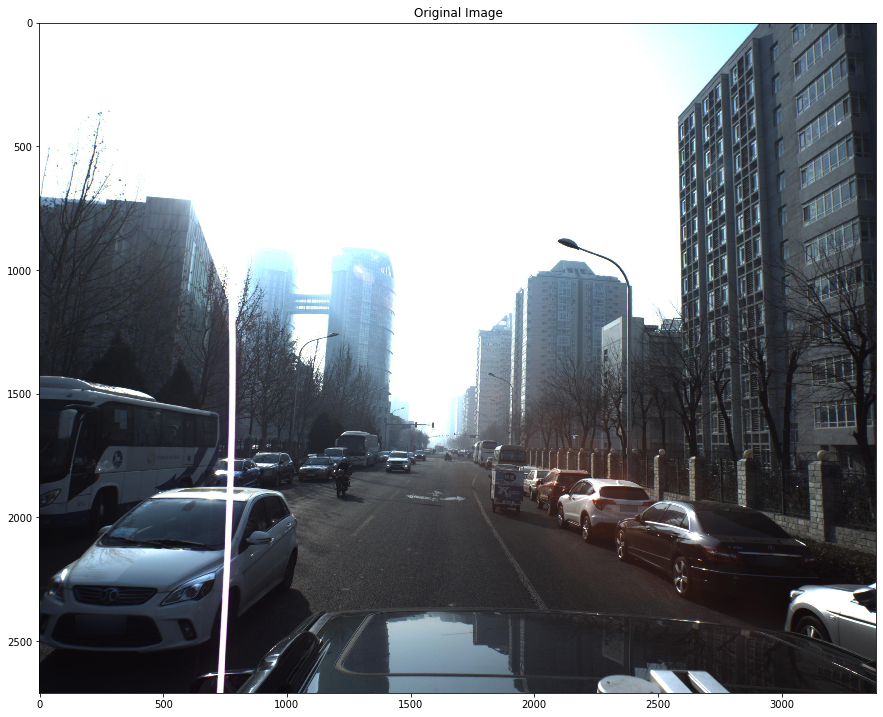

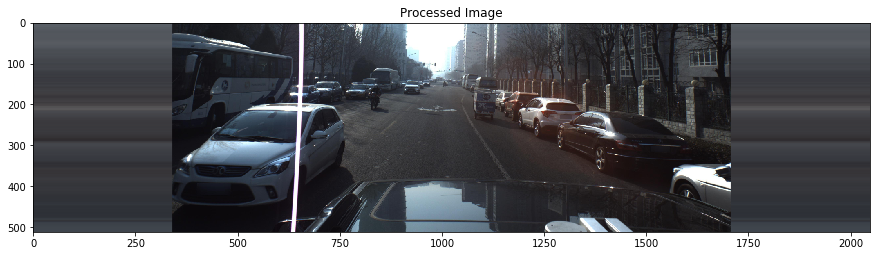

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------

mask.shape (64, 256)
mask.max (64, 256) max: 1.0
regr.shape (64, 256, 7)


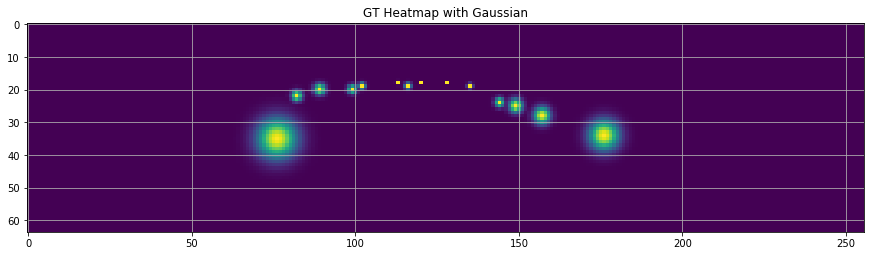

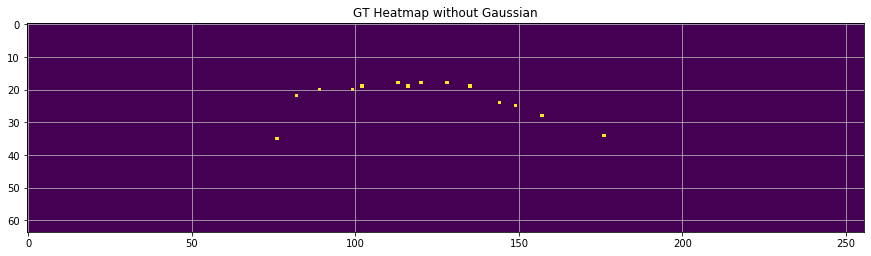

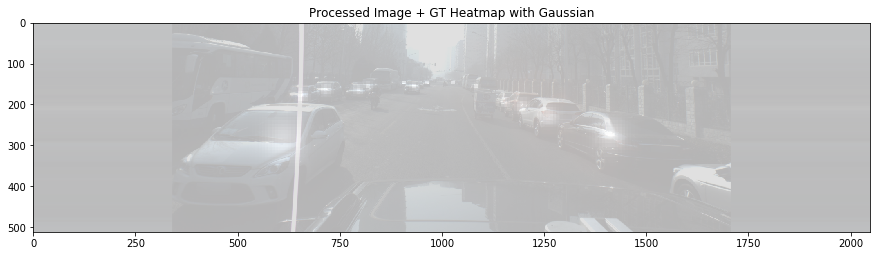

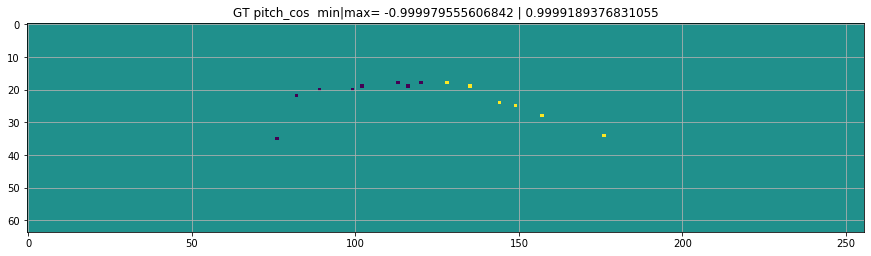

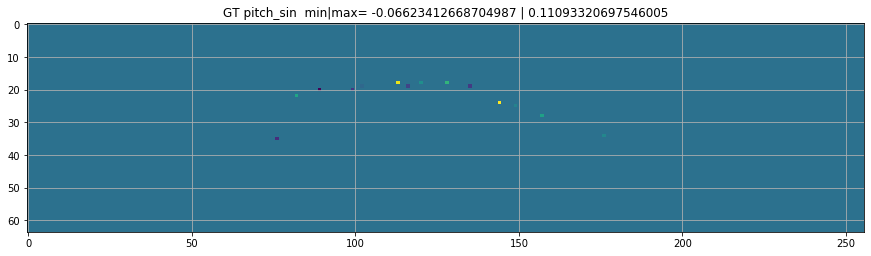

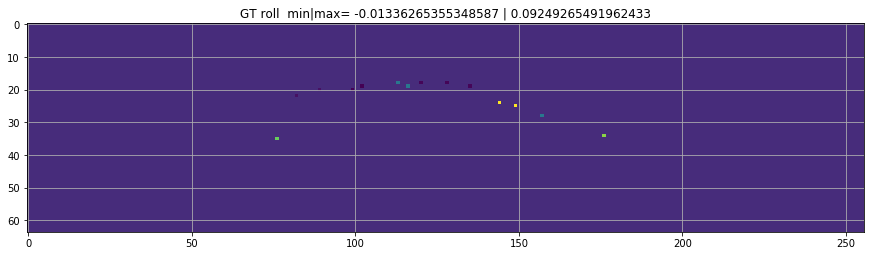

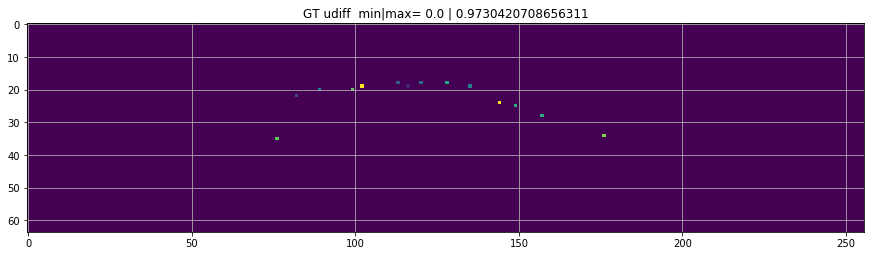

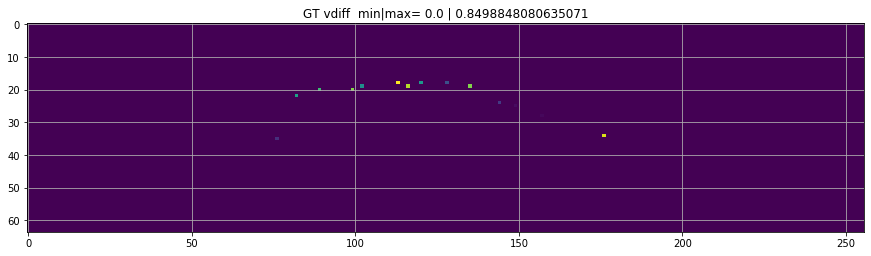

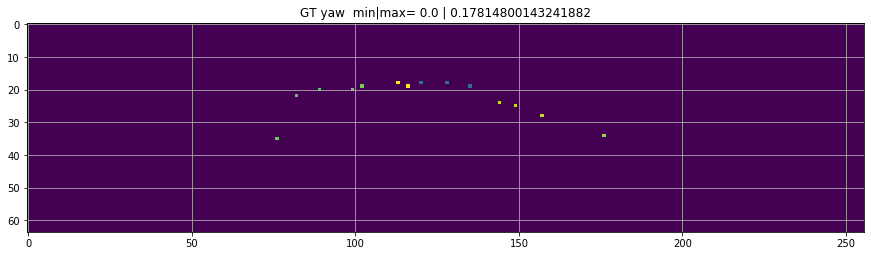

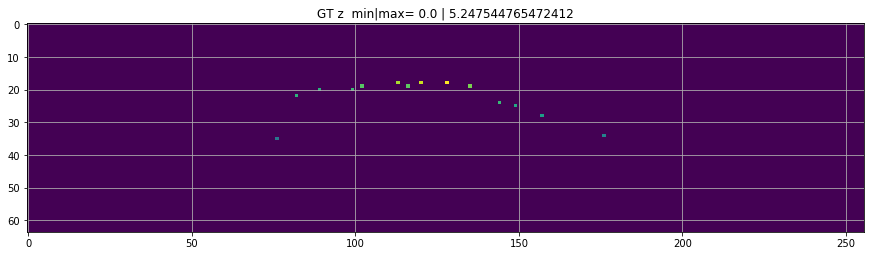

In [36]:
## Plot original and transformed image, then various ground truth regression plane value plots

tmp_idx = 23

img0 = read_image(HOMEDIR + 'train_images/' + df_dev['ImageId'][tmp_idx] + '.jpg')
img = preprocess_image(img0)

mask, regr = get_mask_and_regr(img0, df_dev['PredictionString'][tmp_idx])

print(f"{'-' * 50}\n{'-' * 50}\n{'-' * 50}\n")

print('Image name', dfTrain['ImageId'][tmp_idx])
print('img.shape', img.shape)

plt.figure(figsize=(15,15))
plt.title('Original Image')
plt.imshow(img0)
plt.savefig(OUTDIR + 'Orig_Image.jpg')
plt.show()

plt.figure(figsize=(15,15))
plt.title('Processed Image')
plt.imshow(img)
plt.savefig(OUTDIR + 'Processed_Image.jpg')
plt.show()

print(f"{'-' * 50}\n{'-' * 50}\n{'-' * 50}\n")

print('mask.shape', mask.shape)
print('mask.max', mask.shape, 'max:', np.max(mask))
print('regr.shape', regr.shape)

plt.figure(figsize=(15,15))
plt.title('GT Heatmap with Gaussian')
plt.grid()
plt.imshow(mask)
plt.savefig(OUTDIR + 'GT_HM_with_Gaussian.jpg')
plt.show()

plt.figure(figsize=(15,15))
plt.title('GT Heatmap without Gaussian')
plt.grid()
plt.imshow(mask == 1)
plt.savefig(OUTDIR + 'GT_HM_without_Gaussian.jpg')
plt.show()

plt.figure(figsize=(15,15))
plt.title('Processed Image + GT Heatmap with Gaussian')
_mm = np.repeat( np.repeat(mask, 8, axis=0), 8, axis=1 )[:,:, None]
plt.imshow(0.6 * img + 0.4 * _mm, alpha=0.3)
plt.savefig(OUTDIR + 'Processed_Image_and_GT_HM_Gaussian.jpg')
plt.show()

assert(regr.shape[2] == len(REGR_TARGETS))

## show GT pitch_cos
plt.figure(figsize=(15,15))
plt.title("GT pitch_cos  min|max= {} | {}".format(np.min(regr[:,:,0]), np.max(regr[:,:,0]) ))
plt.grid()
plt.imshow(regr[:,:,0])#, cmap='Greys_r')
plt.savefig(OUTDIR + 'GT_pitch_cos.jpg')
plt.show()

## show GT pitch_sin
plt.figure(figsize=(15,15))
plt.title("GT pitch_sin  min|max= {} | {}".format(np.min(regr[:,:,1]), np.max(regr[:,:,1]) ))
plt.grid()
plt.imshow(regr[:,:,1])#, cmap='Greys_r')
plt.savefig(OUTDIR + 'GT_pitch_sin.jpg')
plt.show()

## show GT roll
plt.figure(figsize=(15,15))
plt.title("GT roll  min|max= {} | {}".format(np.min(regr[:,:,2]), np.max(regr[:,:,2]) ))
plt.grid()
plt.imshow(regr[:,:,2])#, cmap='Greys_r')
plt.savefig(OUTDIR + 'GT_roll.jpg')
plt.show()

## show GT udiff
plt.figure(figsize=(15,15))
plt.title("GT udiff  min|max= {} | {}".format(np.min(regr[:,:,3]), np.max(regr[:,:,3]) ))
plt.grid()
plt.imshow(regr[:,:,3])#, cmap='Greys_r')
plt.savefig(OUTDIR + 'GT_udiff.jpg')
plt.show()

## show GT vdiff
plt.figure(figsize=(15,15))
plt.title("GT vdiff  min|max= {} | {}".format(np.min(regr[:,:,4]), np.max(regr[:,:,4]) ))
plt.grid()
plt.imshow(regr[:,:,4])#, cmap='Greys_r')
plt.savefig(OUTDIR + 'GT_vdiff.jpg')
plt.show()

## show GT yaw
plt.figure(figsize=(15,15))
plt.title("GT yaw  min|max= {} | {}".format(np.min(regr[:,:,5]), np.max(regr[:,:,5]) ))
plt.grid()
plt.imshow(regr[:,:,5])#, cmap='Greys_r')
plt.savefig(OUTDIR + 'GT_yaw.jpg')
plt.show()

## show GT z
plt.figure(figsize=(15,15))
plt.title("GT z  min|max= {} | {}".format(np.min(regr[:,:,6]), np.max(regr[:,:,6]) ))
plt.grid()
plt.imshow(regr[:,:,6])#, cmap='Greys_r')
plt.savefig(OUTDIR + 'GT_z.jpg')
plt.show()


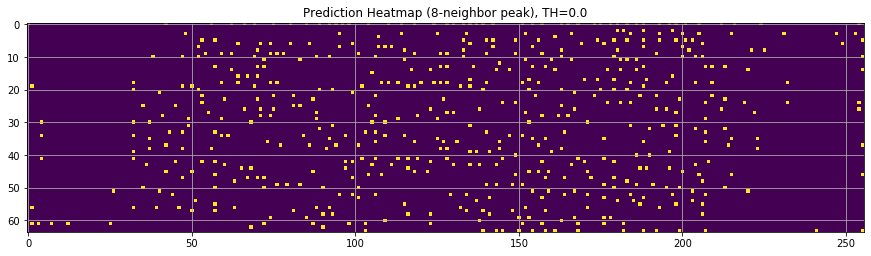

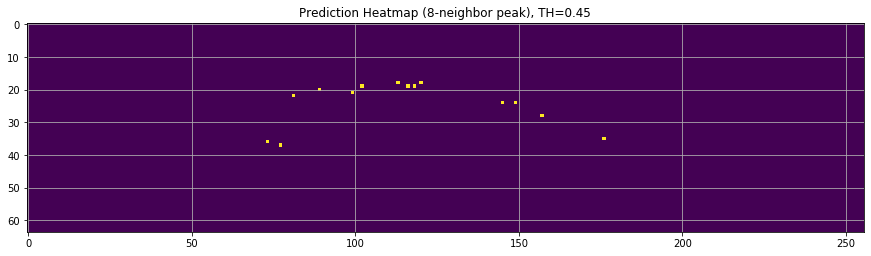

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------



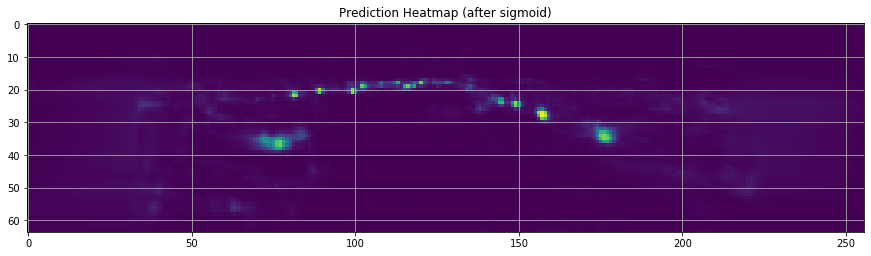

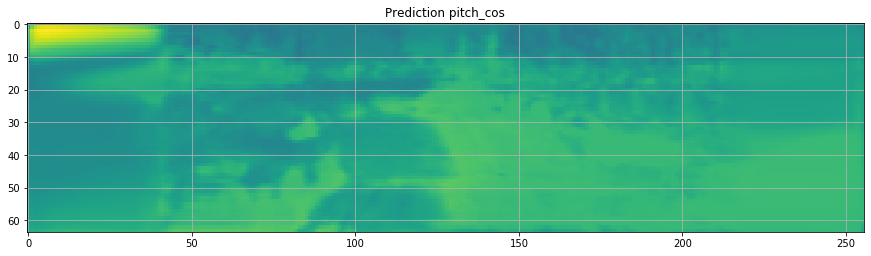

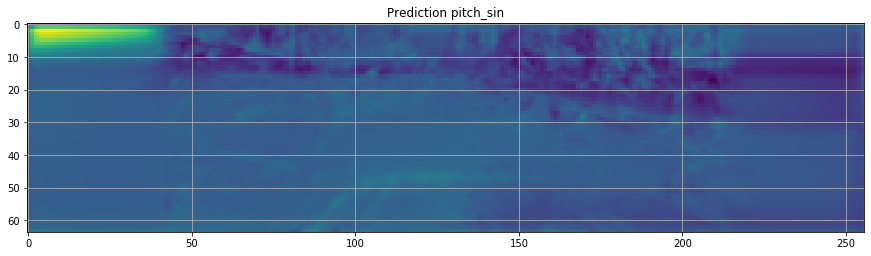

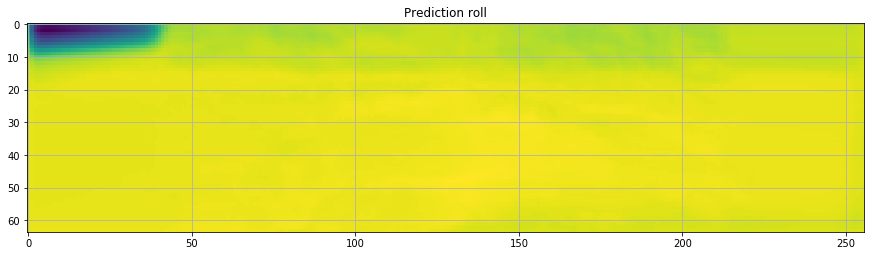

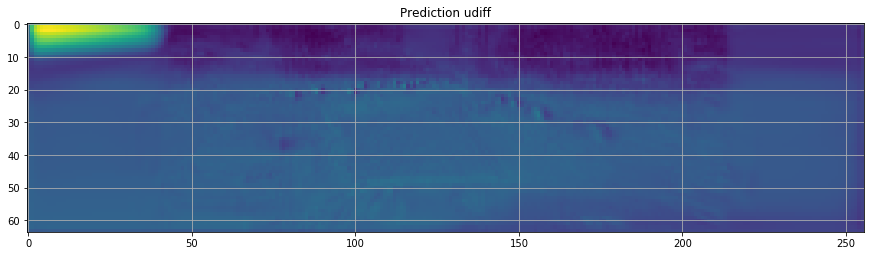

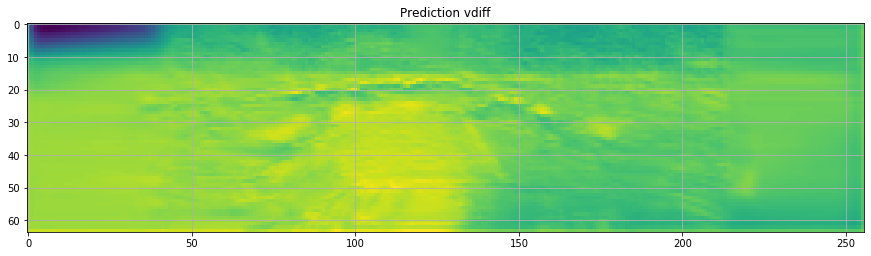

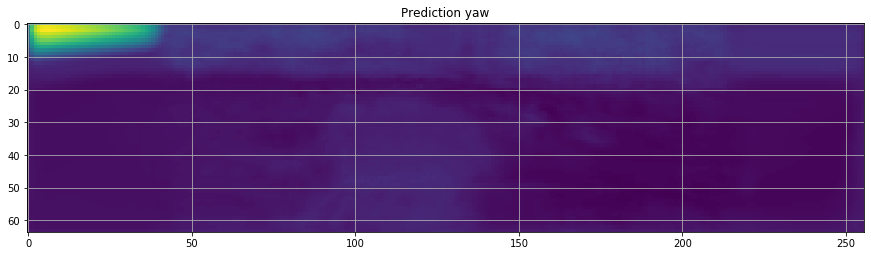

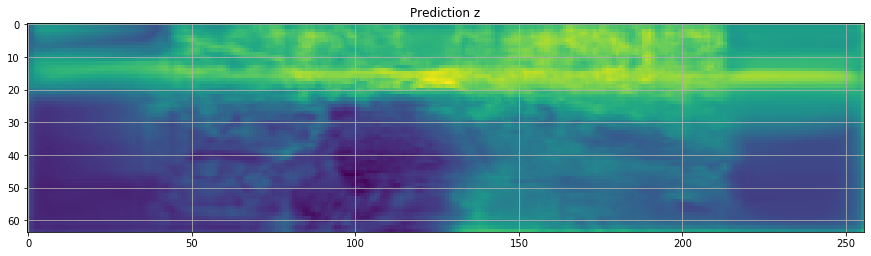

In [37]:
tmp_idx = 0
img, mask, regr, ign_mask, ign_mask_for_feed = dev_dataset[tmp_idx]

if USEMASK:
    output = infer_image(img[None], ign_mask_for_feed[None])
else:
    output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(15,15))
plt.title('Prediction Heatmap (8-neighbor peak), TH=0.0')
plt.grid()
plt.imshow(postprocess_heatmap( logits, thresh=0.0 ))
plt.savefig(OUTDIR + insertNum + 'Pred_HM_8peak_TH_0.0.jpg')
plt.show()

plt.figure(figsize=(15,15))
plt.title('Prediction Heatmap (8-neighbor peak), TH=0.45')
plt.grid()
plt.imshow(postprocess_heatmap( logits, thresh=0.45 ))
plt.savefig(OUTDIR + insertNum + 'Pred_HM_8peak_TH_0.45.jpg')
plt.show()

print(f"{'-' * 50}\n{'-' * 50}\n{'-' * 50}\n")

## regr targets = ['pitch_cos', 'pitch_sin', 'roll', 'udiff', 'vdiff', 'yaw', 'z']
## output.shape = torch.Size([1, 8, 64, 256])

regr_targets_pitch_cos = output[0,1].data.cpu().numpy()
regr_targets_pitch_sin = output[0,2].data.cpu().numpy()
regr_targets_roll = output[0,3].data.cpu().numpy()
regr_targets_udiff = output[0,4].data.cpu().numpy()
regr_targets_vdiff = output[0,5].data.cpu().numpy()
regr_targets_yaw = output[0,6].data.cpu().numpy()
regr_targets_z = output[0,7].data.cpu().numpy()


## show prediction heatmap
plt.figure(figsize=(15,15))
plt.title('Prediction Heatmap (after sigmoid)')
plt.grid()
plt.imshow(sigmoid(logits))
plt.savefig(OUTDIR + insertNum + 'Pred_HM.jpg')
plt.show()

## show prediction pitch_cos
plt.figure(figsize=(15,15))
plt.title('Prediction pitch_cos')
plt.grid()
plt.imshow(regr_targets_pitch_cos)#, cmap='Greys_r')
plt.savefig(OUTDIR + insertNum + 'Pred_pitch_cos.jpg')
plt.show()

## show prediction pitch_sin
plt.figure(figsize=(15,15))
plt.title('Prediction pitch_sin')
plt.grid()
plt.imshow(regr_targets_pitch_sin)#, cmap='Greys_r')
plt.savefig(OUTDIR + insertNum + 'Pred_pitch_sin.jpg')
plt.show()

## show prediction roll
plt.figure(figsize=(15,15))
plt.title('Prediction roll')
plt.grid()
plt.imshow(regr_targets_roll)#, cmap='Greys_r')
plt.savefig(OUTDIR + insertNum + 'Pred_roll.jpg')
plt.show()

## show prediction udiff
plt.figure(figsize=(15,15))
plt.title('Prediction udiff')
plt.grid()
plt.imshow(regr_targets_udiff)#, cmap='Greys_r')
plt.savefig(OUTDIR + insertNum + 'Pred_udiff.jpg')
plt.show()

## show prediction vdiff
plt.figure(figsize=(15,15))
plt.title('Prediction vdiff')
plt.grid()
plt.imshow(regr_targets_vdiff)#, cmap='Greys_r')
plt.savefig(OUTDIR + insertNum + 'Pred_vdiff.jpg')
plt.show()

## show prediction yaw
plt.figure(figsize=(15,15))
plt.title('Prediction yaw')
plt.grid()
plt.imshow(regr_targets_yaw)#, cmap='Greys_r')
plt.savefig(OUTDIR + insertNum + 'Pred_yaw.jpg')
plt.show()

## show prediction z
plt.figure(figsize=(15,15))
plt.title('Prediction z')
plt.grid()
plt.imshow(regr_targets_z)#, cmap='Greys_r')
plt.savefig(OUTDIR + insertNum + 'Pred_z.jpg')
plt.show()

In [38]:
## Simple test of probabilities
actfunc = torch.nn.Sigmoid()
logitnp = torch.from_numpy(logits)
probs = actfunc(logitnp)
probs = probs[probs>00.00]
print(probs)

tensor([1.1254e-03, 1.5165e-04, 2.1995e-05,  ..., 3.7484e-03, 4.5041e-03,
        6.2490e-03])


In [39]:
output.shape

torch.Size([1, 8, 64, 256])

In [40]:
regr_targets_pitch_cos.shape

(64, 256)

In [41]:
logits.shape

(64, 256)